컨브넷의 시각화 기법
1. 컨브넷 중간층의 출력을 시각화하기 -> 컨브넷 층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됨
2. 컨브넷 시각화하기 -> 필터가 찾으려는 시각적 패턴과 개념 상세 이해
3. 클래스 활성화에 대한 히트맵을 이미지에 시각화 -> 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체 위치를 추정하는 데 도움


In [12]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/DataSets/cat dog/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [2]:
img_path = '/content/drive/MyDrive/DataSets/cat dog/cats_and_dogs_small/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) #이미지를 4D 텐서로 변경, 입력 데이터의 첫 번째 차원은 배치 차원인데 데이터가 하나뿐이더라고 입력 데이터의 차원을 맞춰야 하기 때문
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


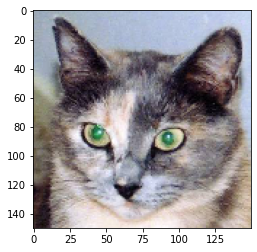

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [4]:
#입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [5]:
activations = activation_model.predict(img_tensor) #층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트 반환

1/1 [==============================] - 1s 1s/step


In [6]:
first_layer_activation = activations[0] #첫 번째 합성곱 층의 활성화 값
print(first_layer_activation.shape) #32개의 채널을 가진 148*148 크기의 특성 맵

(1, 148, 148, 32)


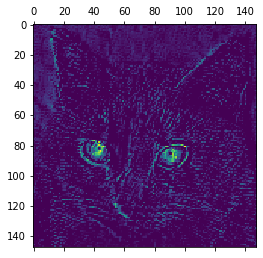

In [7]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0,:,:,19], cmap='viridis') #첫 번째 활성화 층 활성화 중 20번째 채널

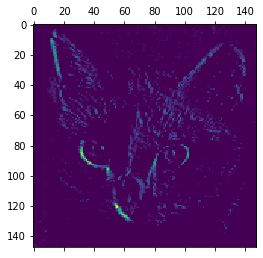

In [8]:
plt.matshow(first_layer_activation[0,:,:,15], cmap='viridis')

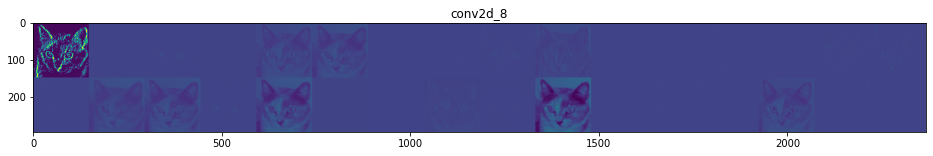

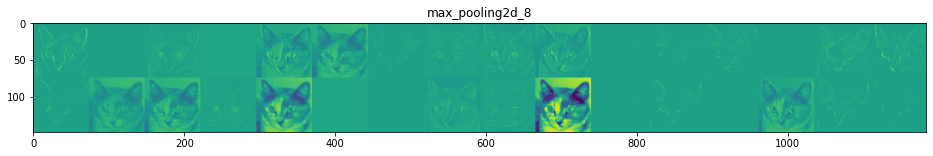

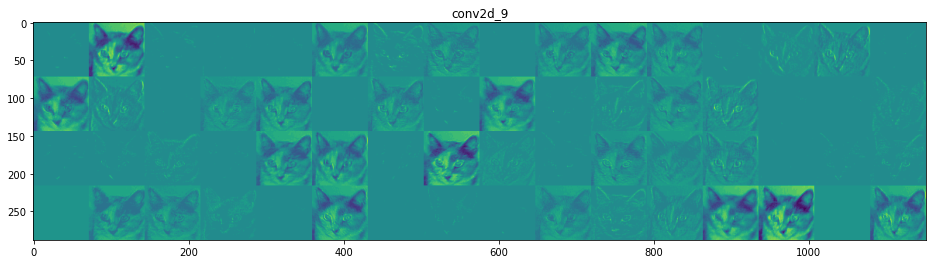

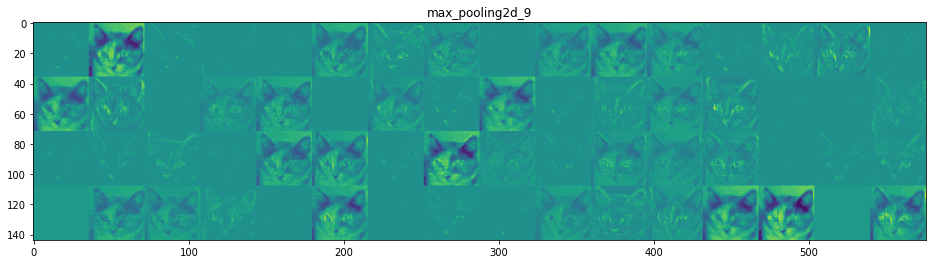

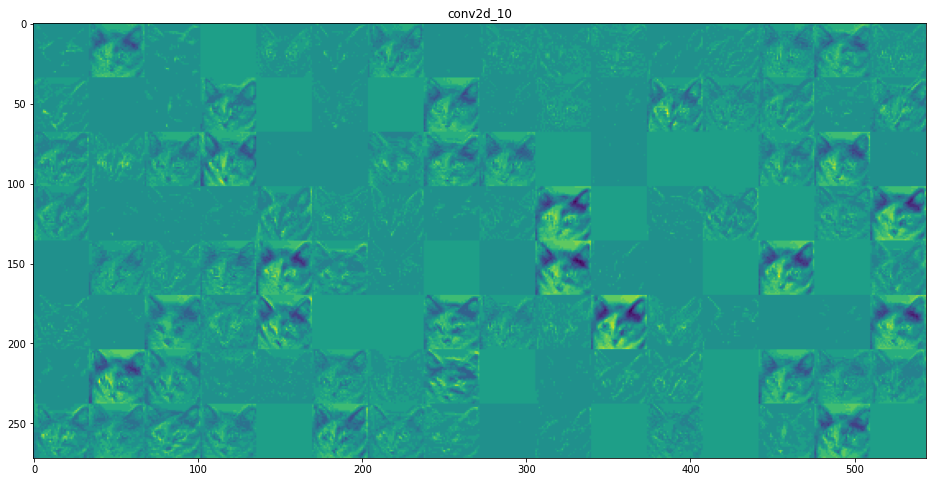

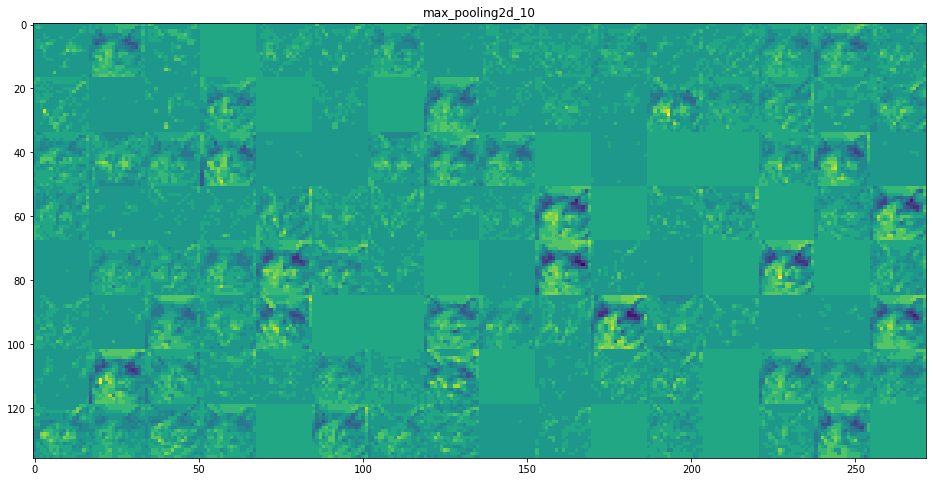

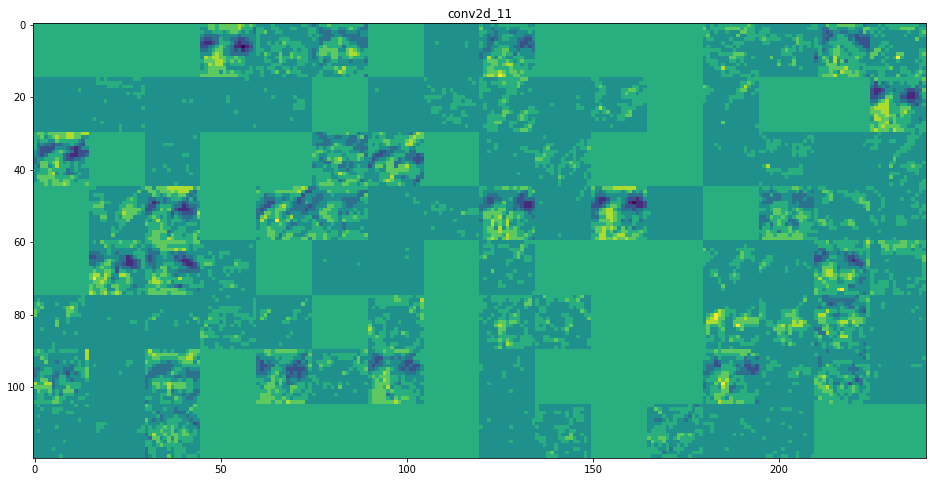

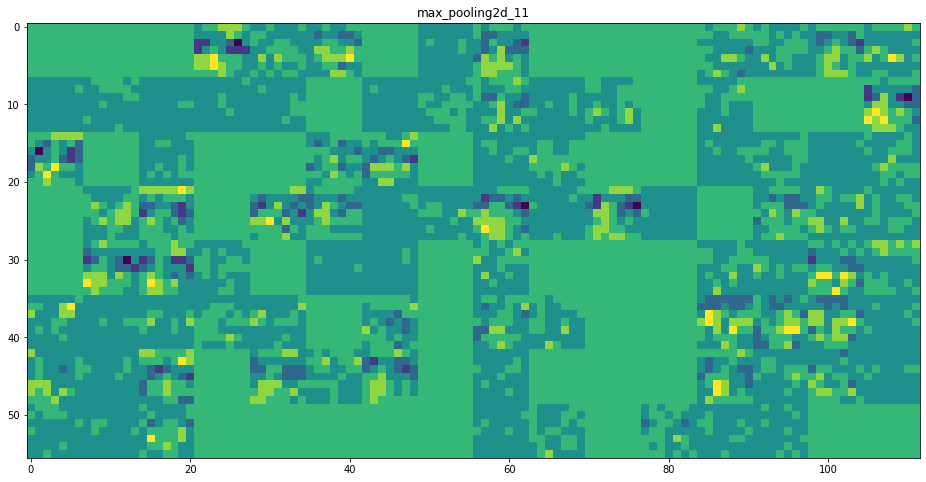

In [10]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name) #층의 이름을 그래프 제목으로 사용

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): #특성 맵 그리기
  n_features = layer_activation.shape[-1] #특성 맵에 있는 특성의 수

  size = layer_activation.shape[1] # 특성 맵의 크기는 (1, size, size, n_features)

  n_cols = n_features // images_per_row #활성화 채널을 위한 그리드 크기
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols): #각 활성화를 하나의 큰 그리드에 채움
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean() #그래프로 나타내기 좋게 특성 처리 -> 표준화(x-mean/std) -> 95퍼센트 이내 값들이 0~255 사이에 놓이도록 증폭시킨 후 클리핑
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

  scale = 1./size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap = 'viridis')

plt.show()

# 5.4.2 컨브넷 필터 시각화하기

In [20]:
#필터 시각화를 위한 손실 텐서 정의
from keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top = False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [24]:
grads = K.gradients(loss, model.input)[0] #그래디언트 함수가 반환하는 텐서 리스트(여기서는 크기가 1인 리스트)에서 첫 번째 텐서 추출

In [25]:
#그래디언트 정규화(L2 노름)
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #나눗셈을 방지하기 위해 1e-5를 더함

In [26]:
#입력 값에 대한 넘파이 출력 값 추출
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [27]:
# 확률적 경사 상승법을 사용한 손실 최대화하기
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128 #잡음 섞인 회색 이미지

step = 1. #업데이트할 그래디언트 크기
for i in range(40): #경사 상승법 40회 실행
  loss_value, grads_value = iterate([input_img_data]) #손실과 그래디언트 계산

  input_img_data += grads_value * step #손실을 최대화하는 방향으로 입력 이미지 수정

In [28]:
#텐서를 이미지 형태로 변환하기 위한 유틸리티 함수 -> 표준 점수 5배수 이내에 있는 값들을 0~255 사이로 압축
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1 #평균이 0, 표준 편차가 0.1이 되도록 정규화

  x += 0.5
  x = np.clip(x, 0, 1)

#RGB 배열로 변환
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [33]:
#필터 시각화 이미지를 만드는 함수

def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  grads = K.gradients(loss, model.input)[0] #손실에 대한 입력 이미지의 그래디언트 계산

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #L2 norm

  iterate = K.function([model.input], [loss, grads]) #입력 이미지에 대한 손실과 그래디언트 반환

  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. #잡음 섞인 회색 이미지

  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

  img = input_img_data[0]
  return deprocess_image(img)

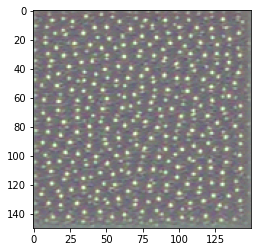

In [34]:
plt.imshow(generate_pattern('block3_conv1', 0))

In [38]:
#층에 있는 각 필터에 반응하는 패턴 생성하기

layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype = 'uint8') #결과를 담을 빈 (검은) 이미지

for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)

Output hidden; open in https://colab.research.google.com to view.

# 5.4.3 클래스 활성화의 히트맵 시각화하기

입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출한 후 특성 맵의 모든 채널 출력에 채널에 대한 클래스의 그래디언트 평균을 곱함

입력 이미지가 각 채널을 활성화하는 정도에 대한 공간적인 맵을 클래스에 대한 각 채널의 중요도로 가중치를 부여하여 입력 이미지가 클래스를 활성화하는 정도에 대한 공간적인 맵을 만드는 것

In [39]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet') #최상단 완전 연결 분류기 포함

553467096/553467096 [==============================] - 7s 0us/step


In [40]:
#VGG 16을 위한 입력 이미지 전처리
from keras_preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/MyDrive/DataSets/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size = (224, 224))

x = image.img_to_array(img) # (224, 224, 3) 크기의 넘파이 float32 배열

x = np.expand_dims(x, axis=0) # (1, 224, 224, 3)

x = preprocess_input(x) #데이터 전처리, 채널별 컬러 정규화 수행

In [41]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


35363/35363 [==============================] - 0s 0us/step
Predicted:  [('n02504458', 'African_elephant', 0.8548977), ('n01871265', 'tusker', 0.13017415), ('n02504013', 'Indian_elephant', 0.011699438)]


In [42]:
np.argmax(preds[0])

386

In [44]:
#Grad-CAM 알고리즘 설정하기
african_elephant_output = model.output[:,386]

last_conv_layer = model.get_layer('block5_conv3') #VGG 16 마지막 합성곱 층인 block5_conv3 층의 특성 맵

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis = (0, 1, 2)) #특성 맵 채널별 그래디언트 평균값이 담긴 (512, ) 크기의 벡터

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

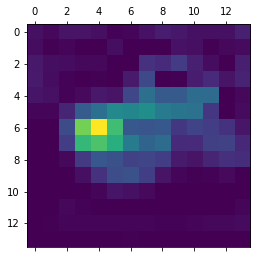

In [45]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [49]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) #히트맵을 원본 이미지 크기에 맞게 변경

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/drive/MyDrive/DataSets/elephant_cam.jpg', superimposed_img)

True

In [58]:
img_path = '/content/drive/MyDrive/DataSets/elephant_cam.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) #이미지를 4D 텐서로 변경, 입력 데이터의 첫 번째 차원은 배치 차원인데 데이터가 하나뿐이더라고 입력 데이터의 차원을 맞춰야 하기 때문
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


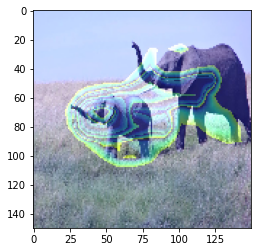

In [59]:
plt.imshow(img_tensor[0])
plt.show()